# Create context-specific models using DeepRed Omics data
## Setup
### Import packages

In [ ]:
import gurobipy as gp
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib_venn as mpl_venn
import numpy as np
import pandas as pd
import seaborn as sns
import sympy
from rbc_gem_utils import (
    COBRA_CONFIGURATION,
    get_dirpath,
    read_cobra_model,
    show_versions,
    write_cobra_model,
)
from rbc_gem_utils.analysis.overlay import (
    ProteinDilution,
    add_relaxation_budget,
    load_overlay_model,
    update_slack_value,
)
from rbc_gem_utils.util import AVOGADRO_NUMBER, DEFAULT_DRY_MASS_PER_CELL
from sklearn.metrics import r2_score

gp.setParam("OutputFlag", 0)
gp.setParam("LogToConsole", 0)

# Show versions of notebook
show_versions()

Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-21

Package Information
-------------------
rbc-gem-utils 0.0.1

Dependency Information
----------------------
beautifulsoup4                       4.12.3
bio                                   1.6.2
cobra                                0.29.0
depinfo                               2.2.0
kaleido                               0.2.1
matplotlib                            3.8.2
memote                               0.17.0
networkx                              3.2.1
notebook                              7.0.7
openpyxl                              3.1.2
pandas                                2.2.0
pre-commit                            3.6.0
pyvis                                 0.3.2
rbc-gem-utils[database,network,vis] missing
requests                             2.31.0
scipy                                1.12.0
seaborn                              0.13.2

Build Tools Information
-----------------------
pip 

### Define configuration
#### COBRA Configuration

In [2]:
COBRA_CONFIGURATION.solver = "gurobi"
COBRA_CONFIGURATION.bounds = (-1e8, 1e8)
COBRA_CONFIGURATION

Attribute,Description,Value
solver,Mathematical optimization solver,gurobi
tolerance,"General solver tolerance (feasibility, integrality, etc.)",1e-07
lower_bound,Default reaction lower bound,-100000000.0
upper_bound,Default reaction upper bound,100000000.0
processes,Number of parallel processes,15
cache_directory,Path for the model cache,/Users/zhaiman/Library/Caches/cobrapy
max_cache_size,Maximum cache size in bytes,104857600
cache_expiration,Model cache expiration time in seconds (if any),None


## Define organism, model, and dataset

In [3]:
organism = "Human"
model_id = "RBC_GEM"
dataset_name = "DeepRedOmics"

## Load RBC-GEM model

In [4]:
valid_organisms = {"Human", "Mouse"}
if organism not in valid_organisms:
    raise ValueError(f"Organism must be one of the following: {valid_organisms}")

# Set paths
proteomics_dirpath = (get_dirpath("proteomics", use_temp="raw") / organism / dataset_name).resolve()
overlay_dirpath = (get_dirpath("analysis") / "OVERLAY" / organism).resolve()
model_dirpath = overlay_dirpath / model_id

results_dirpath = (get_dirpath(use_temp="processed") / model_id / "OVERLAY" / organism / dataset_name).resolve()
fitting_dirpath = results_dirpath / "fitting"
sample_pcmodels_dirpath = results_dirpath / "sample_pcmodels"
# Ensure directories exist
results_dirpath.mkdir(exist_ok=True, parents=True)
fitting_dirpath.mkdir(exist_ok=True)
sample_pcmodels_dirpath.mkdir(exist_ok=True)

# Identify hemoglobin proteins
if organism == "Mouse":
    hemoglobin_proteins = {
        k.replace("-", "_"): v
        for k, v in {
            'Hba': "P01942",     # Hemoglobin subunit alpha
            'Hba-a1': "P01942",        
            'Hbb-b1': "P02088",  # Hemoglobin subunit beta-1
            'Hbb-b2': "P02089",  # Hemoglobin subunit beta-2
            'Hbb-bh0': "P04443", # Hemoglobin subunit beta-H0
            'Hbb-bh1': "P04444", # Hemoglobin subunit beta-H1
            'Hbz': "P06467",     # Hemoglobin subunit zeta
            'Hba-x': "P06467",
            'Hbz1': "P06467",   
            'Hbb-y': "P02104",   # Hemoglobin subunit epsilon-Y2
        }.items()
    }
else:
    hemoglobin_proteins = {
        "HBA": "P69905",    # Hemoglobin subunit alpha
        "HBB": "P68871",    # Hemoglobin subunit beta
        "HBD": "P02042",    # Hemoglobin subunit delta
        "HBE1": "P02100",   # Hemoglobin subunit beta
        "HBG1": "P69891",   # Hemoglobin subunit gamma-1
        "HBG2": "P69892",   # Hemoglobin subunit gamma-2
        "HBM": "Q6B0K9",    # Hemoglobin subunit mu
        "HBQ1": "P09105",   # Hemoglobin subunit theta-1
        "HBZ": "P02008",    # Hemoglobin subunit zeta
    }

# Load models
model = read_cobra_model(filename=model_dirpath / f"{model_id}.xml")
pcmodel = load_overlay_model(filename=model_dirpath / f"{model_id}_PC.xml")

pcmodel

Name,RBC_GEM_PC
Memory address,1574f3150
Number of metabolites,10410
Number of reactions,18799
Number of genes,820
Number of groups,78
Objective expression,1.0*NaKt - 1.0*NaKt_reverse_db47e
Compartments,"cytosol, extracellular space, protein compartment"


### Set figure options

In [5]:
save_figures = True
transparent = False
imagetype = "svg"

## Load data
#### Set variables for columns keys 

In [6]:
sample_key = "SAMPLE ID"

### Load copy numbers and protein data

In [7]:
df_copy_numbers = pd.read_csv(
    proteomics_dirpath / f"{dataset_name}_CopyNumbers.tsv",
    sep="\t",
    index_col=None
)
df_copy_numbers = df_copy_numbers.set_index(sample_key)

df_protein_data = pd.read_csv(
    proteomics_dirpath / f"{dataset_name}_ProteinData.tsv",
    sep="\t",
    index_col="Entry",
)

df_copy_numbers = df_copy_numbers.loc[df_copy_numbers[df_protein_data.index].dropna(axis=0, how="all").index]
sample_ids = list(df_copy_numbers.index.unique())
print(f"Number of samples: {len(sample_ids)}")

df_copy_numbers

Number of samples: 1


,A0A024RBG1,A0A075B6I9,A0A075B6K5,A0A075B6P5,A0A075B6R9,A0A075B6S2,A0A0A0MRZ8,A0A0C4DH25,A0A0C4DH41,A0A1W2PR19,...,Q9Y6M1,Q9Y6M4,Q9Y6M5,Q9Y6N5,Q9Y6P5,Q9Y6R4,Q9Y6U3,Q9Y6W3,Q9Y6W5,Q9Y6Y8
SAMPLE ID,,,,,,,,,,,,,,,,,,,,,
DeepRedOmics,4721.116599,15021.40978,609.550609,38381.33516,3124.21758,6557.865957,10352.39291,2136.1758,2177.580856,1706.116041,...,321.00004,29094.65457,307431.0413,689.048171,5653.931616,103.500561,655.143138,7630.705577,52631.87621,8313.38099


## Integrate proteomics with model
### Convert copy numbers to mg / gDW

In [8]:
df_uniprot_to_mw = df_protein_data["Mass"] / 1000  # g/mol --> # kg / mol
df_mg_prot_per_gDW = (
    df_copy_numbers  # protein copies / cell
    * (1 / DEFAULT_DRY_MASS_PER_CELL)  # cell / pgDW
    * (1e12 / 1)  # pgDW / gDW
    * (1 / AVOGADRO_NUMBER)  # mol / protein copies
    * (df_uniprot_to_mw)  # kg / mol
    * (1e6 / 1)  # mg / kg
).copy()
df_mg_prot_per_gDW

,A0A024RBG1,A0A075B6I9,A0A075B6K5,A0A075B6P5,A0A075B6R9,A0A075B6S2,A0A0A0MRZ8,A0A0C4DH25,A0A0C4DH41,A0A1W2PR19,...,Q9Y6M1,Q9Y6M4,Q9Y6M5,Q9Y6N5,Q9Y6P5,Q9Y6R4,Q9Y6U3,Q9Y6W3,Q9Y6W5,Q9Y6Y8
SAMPLE ID,,,,,,,,,,,,,,,,,,,,,
DeepRedOmics,0.00534,0.010367,0.000416,0.027527,0.002262,0.004771,0.007234,0.00148,0.001575,0.002639,...,0.001175,0.082758,0.941024,0.001905,0.0177,0.001041,0.002919,0.039133,0.158142,0.051112


### Scale measurements for proteome budget
Note that this step will help ensure its theoretically possible for a perfect fit 

In [9]:
la_proteome_budget_value = 50
hemoglobin_budget_value = 950
total_budget_value = None

In [10]:
# Split into hemoglobin and low abundance proteomes
df_mg_prot_per_gDW_hb = df_mg_prot_per_gDW.loc[:, df_mg_prot_per_gDW.columns.isin(hemoglobin_proteins.values())]
df_mg_prot_per_gDW_la = df_mg_prot_per_gDW.loc[:, ~df_mg_prot_per_gDW.columns.isin(hemoglobin_proteins.values())]

df_summary = {
    "Perfect total": 1000,
    "Current total": df_mg_prot_per_gDW.loc[sample_ids].sum(axis=1).mean().item(),
    "Hemoglobin total": df_mg_prot_per_gDW_hb.loc[sample_ids].sum(axis=1).mean().item(),
    "Low abundance total": df_mg_prot_per_gDW_la.loc[sample_ids].sum(axis=1).mean().item(),
}
df_summary["Remaining/Excess"] = df_summary["Perfect total"] - (
    df_summary["Hemoglobin total"] + df_summary["Low abundance total"]
)

PBDL_proteome_budget = pcmodel.reactions.get_by_id("PBDL_proteome_budget")
PBDL_hemoglobin_budget = pcmodel.reactions.get_by_id("PBDL_hemoglobin_budget")
PBDL_total_budget = pcmodel.reactions.get_by_id("PBDL_total_budget")

if la_proteome_budget_value is None:
    la_proteome_budget_value = PBDL_proteome_budget.upper_bound
if hemoglobin_budget_value is None:
    hemoglobin_budget_value = PBDL_hemoglobin_budget.upper_bound
if total_budget_value is None:
    total_budget_value = PBDL_total_budget.upper_bound

assert total_budget_value >= (la_proteome_budget_value + hemoglobin_budget_value)

PBDL_proteome_budget.upper_bound = la_proteome_budget_value
PBDL_hemoglobin_budget.upper_bound = hemoglobin_budget_value
PBDL_total_budget.upper_bound = total_budget_value

# Scale values for low abundance proteome
budget_value = la_proteome_budget_value
df_mg_prot_per_gDW_la = (
    budget_value * (df_mg_prot_per_gDW_la.T / df_mg_prot_per_gDW_la.sum(axis=1)).T
)
df_summary["Low abundance scaled"] = budget_value

# Scale values for hemoglobin proteome
budget_value = hemoglobin_budget_value
df_mg_prot_per_gDW_hb = (
    budget_value * (df_mg_prot_per_gDW_hb.T / df_mg_prot_per_gDW_hb.sum(axis=1)).T
)
df_summary["Hemoglobin scaled"] = budget_value

budget_value = total_budget_value - sum(
    [la_proteome_budget_value, hemoglobin_budget_value]
)
df_summary["Remaining scaled"] = budget_value

# Combine dataframes back into one
df_mg_prot_per_gDW_normalized = pd.concat(
    (df_mg_prot_per_gDW_hb, df_mg_prot_per_gDW_la), axis=1
)
df_summary = pd.DataFrame.from_dict(
    {
        " " * max(30 - len(k), 0) + k: [f"{v:.4f}", f"{v / 1000 * 100:.1f}%"]
        for k, v in df_summary.items()
    },
    orient="index",
    columns=["mg protein / gDW / cell", "Percentage"],
)
print(df_summary)
df_mg_prot_per_gDW_normalized.sum(axis=1)

                     mg protein / gDW / cell Percentage
       Perfect total               1000.0000     100.0%
       Current total               2039.5138     204.0%
    Hemoglobin total                398.5474      39.9%
 Low abundance total               1640.9664     164.1%
    Remaining/Excess              -1039.5138    -104.0%
Low abundance scaled                 50.0000       5.0%
   Hemoglobin scaled                950.0000      95.0%
    Remaining scaled                  0.0000       0.0%


SAMPLE ID
DeepRedOmics    1000.0
dtype: float64

### Convert mg / gDW to nmol / gDW

In [11]:
df_nmol_prot_per_gDW = (
    df_mg_prot_per_gDW_normalized  # mg / gDW
    * (1 / df_uniprot_to_mw)  # mol / kg --> mmol / g --> umol / mg
    * (1e3 / 1)  # nmol / umol
).loc[:, df_mg_prot_per_gDW_normalized.columns]
df_nmol_prot_per_gDW = df_nmol_prot_per_gDW.T
df_nmol_prot_per_gDW

SAMPLE ID,DeepRedOmics
P02008,571.499749
P02042,11681.914037
P02100,3835.038390
P09105,83.511852
P68871,17545.633065
...,...
Q9Y6R4,0.000175
Q9Y6U3,0.001105
Q9Y6W3,0.012870
Q9Y6W5,0.088766


## Create DataFrame for protein dilution reactions

In [12]:
df_model_protein_dilutions = pd.concat(
    (
        pd.Series(
            {g.annotation.get("uniprot"): g.id for g in model.genes}, name="genes"
        ),
        pd.Series(
            {
                protdl.annotation.get("uniprot"): protdl.id
                for protdl in pcmodel.reactions.query(
                    lambda x: isinstance(x, ProteinDilution)
                )
            },
            name="PROTDL",
        ),
    ),
    axis=1,
)
df_model_protein_dilutions.index.name = "uniprot"
df_model_protein_dilutions = df_model_protein_dilutions[
    df_model_protein_dilutions["genes"].isin(model.genes.list_attr("id"))
].sort_values("PROTDL")
df_model_protein_dilutions

,genes,PROTDL
uniprot,,
Q9NPC4,A4GALT,PROTDL_protein_A4GALT_pc
P49588,AARS1,PROTDL_protein_AARS1_pc
Q9NRN7,AASDHPPT,PROTDL_protein_AASDHPPT_pc
O95477,ABCA1,PROTDL_protein_ABCA1_pc
Q8IZY2,ABCA7,PROTDL_protein_ABCA7_pc
...,...,...
P07947,YES1,PROTDL_protein_YES1_pc
Q5W0Z9,ZDHHC20,PROTDL_protein_ZDHHC20_pc
Q9UIJ5,ZDHHC2,PROTDL_protein_ZDHHC2_pc


## Organize samples

In [13]:
run_computations = False
operation_ids = []
df_samples = df_nmol_prot_per_gDW.copy()


### Map samples to model

In [14]:
merge_key = "uniprot"
df_samples.index.name = merge_key

df_model = (
    df_model_protein_dilutions[["PROTDL"]]
    .merge(df_samples, left_index=True, right_index=True, how="left")
    .set_index("PROTDL")
    .sort_index()
)
no_experimental_measurements = [
    protein_dilution
    for protein_dilution, has_measurement in df_model.isna().all(axis=1).items()
    if has_measurement
]
print(
    f"Model proteins mapped to measurements: {len(df_model) - len(no_experimental_measurements)}"
)
print(f"Model proteins without measurements: {len(no_experimental_measurements)}")
df_model[~df_model.isna().all(axis=1)]

Model proteins mapped to measurements: 724
Model proteins without measurements: 96


,DeepRedOmics
PROTDL,
PROTDL_protein_AARS1_pc,0.069110
PROTDL_protein_AASDHPPT_pc,0.120440
PROTDL_protein_ABCA7_pc,0.010758
PROTDL_protein_ABCB4_pc,0.000703
PROTDL_protein_ABCB6_pc,0.400265
...,...
PROTDL_protein_YES1_pc,0.029320
PROTDL_protein_ZDHHC20_pc,0.062300
PROTDL_protein_ZDHHC2_pc,0.016674


#### Summarize mapping

In [15]:
dataset_proteins = set(df_samples.index)
model_proteins = set(df_model_protein_dilutions.index)

df_mg_prot_per_gDW_hb = df_mg_prot_per_gDW_normalized.loc[
    [x for x in df_mg_prot_per_gDW_normalized.index if x in sample_ids], # Don't include operation IDs
    [x for x in df_mg_prot_per_gDW_normalized.columns if x in list(hemoglobin_proteins.values())]]
df_mg_prot_per_gDW_la = df_mg_prot_per_gDW_normalized.loc[
    [x for x in df_mg_prot_per_gDW_normalized.index if x in sample_ids], # Don't include operation IDs
    [x for x in df_mg_prot_per_gDW.columns if not x in list(hemoglobin_proteins.values())]
]

df_mapped_mass_la = df_mg_prot_per_gDW_la.loc[
    :, df_mg_prot_per_gDW_la.columns.isin(model_proteins)
].sum(axis=1)
df_unmapped_mass_la = df_mg_prot_per_gDW_la.loc[
    :, ~df_mg_prot_per_gDW_la.columns.isin(model_proteins)
].sum(axis=1)
df_mapped_mass_hb = df_mg_prot_per_gDW_hb.loc[
    :, df_mg_prot_per_gDW_hb.columns.isin(model_proteins)
].sum(axis=1)
df_unmapped_mass_hb = df_mg_prot_per_gDW_hb.loc[
    :, ~df_mg_prot_per_gDW_hb.columns.isin(model_proteins)
].sum(axis=1)

proteomes = {}
round_int = 6
for label, df in zip(
    ["hemoglobin", "low abundance"], [df_mg_prot_per_gDW_hb, df_mg_prot_per_gDW_la]
):
    df_modeled = df.loc[:, df.columns.isin(model_proteins)].sum(axis=1)
    df_remaining = df.loc[:, ~df.columns.isin(model_proteins)].sum(axis=1)
    means = (df_modeled.mean(), df_remaining.mean())
    stdevs = (df_modeled.std(), df_remaining.std())
    proteomes[(label, "modeled")] = round(means[0], round_int)
    proteomes[(label, "remaining")] = round(means[1], round_int)
proteomes = pd.Series(proteomes, name="Mean value across samples")
proteomes.index = [f"Mean {k[0]} mass {k[1]}" for k in proteomes.index]
print(proteomes.head())
proteomes = proteomes[proteomes != 0]

Mean hemoglobin mass modeled         950.000000
Mean hemoglobin mass remaining         0.000000
Mean low abundance mass modeled       20.202305
Mean low abundance mass remaining     29.797695
Name: Mean value across samples, dtype: float64


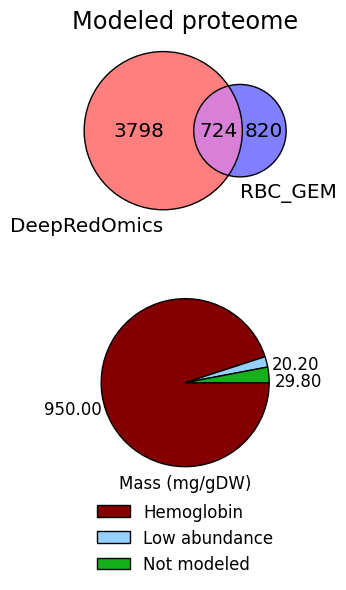

In [16]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(3, 6))
subsets = (
    len(dataset_proteins),
    len(model_proteins),
    len(dataset_proteins.intersection(model_proteins)),
)


venn = mpl_venn.venn2(
    subsets=subsets,
    set_labels=(dataset_name, model.id),
    set_colors=("red", "blue"),
    alpha=0.5,
    ax=ax1,
)
circles = mpl_venn.venn2_circles(
    subsets=subsets, linestyle="-", color="black", ax=ax1, linewidth=1
)
for text in venn.set_labels:
    text.set_fontsize("x-large")
for text in venn.subset_labels:
    text.set_fontsize("x-large")
ax1.set_title("Modeled proteome", fontsize="xx-large")


label_color_map = {
    "Mean hemoglobin mass modeled": ("Hemoglobin", "xkcd:dark red"),
    "Mean low abundance mass modeled": ("Low abundance", "xkcd:light blue"),
    "Mean low abundance mass remaining": ("Not modeled", "xkcd:green"),
}
edgecolor = "black"
linewidth = 1
ax2.pie(
    x=proteomes.values,
    colors=[label_color_map[k][1] for k in proteomes.index],
    pctdistance=1.35,
    counterclock=False,
    autopct=lambda pct: f"{pct * 1000/100:.2f}\n",
    textprops=dict(fontsize="large", ha="center", va="top"),
    wedgeprops=dict(edgecolor=edgecolor, linewidth=linewidth),
)
handles = [
    mpl.patches.Patch(
        edgecolor=edgecolor,
        linewidth=linewidth,
        label=label_color_map[k][0],
        facecolor=label_color_map[k][1],
    )
    for k in proteomes.index
]
ax2.legend(
    handles=handles,
    ncols=1,
    bbox_to_anchor=(0.5, 0),
    loc="upper center",
    fontsize="large",
    frameon=False,
)
ax2.set_xlabel("Mass (mg/gDW)", fontsize="large", labelpad=-10)
if save_figures:
    fig.savefig(
        results_dirpath / f"ModeledProteome.{imagetype}",
        transparent=transparent,
        format=imagetype,
    )
fig;

## Create QP model for each sample

In [17]:
def solve_qp(pcmodel, df):
    x = []  # Variables
    c = []  # Data * Weights
    F = []  # Weights

    for protdl, (data_value, weight) in df.iterrows():
        protdl = pcmodel.reactions.get_by_id(protdl)
        x.append(protdl.flux_expression)
        c.append(weight * data_value)
        F.append(weight)

    x = sympy.Matrix(x)
    c = sympy.Matrix(c)
    F = sympy.DiagMatrix(sympy.Matrix(F))
    # # QP Objective must be in form of 0.5 * x.T * F * x - c.T * x
    objective = 0.5 * x.T * F * x - c.T * x
    pcmodel.objective = objective[0]
    pcmodel.objective_direction = "min"
    pcmodel.tolerance = 1e-9

    qp_sol = pcmodel.optimize()
    return qp_sol


def solve_qp_for_samples(pcmodel, df_samples, df_weights=None, log_zero_replacement=1e-6, verbose=False):
    qp_solutions_dict = {}
    for sample_id, data_series in df_samples.items():
        # Get protein values
        data_series.name = "Data"
        if df_weights is None:
            data_weights = 1 / data_series.replace(0, 1)
            data_weights = data_weights / data_weights.mean()
        else:
            data_weights = df_weights.loc[:, sample_id]
        # Get protein weights
        data_weights.name = "Weights"

        # Map to model, currently model mapping DataFrame generated outside scope of function
        df_model_data_weights = (
            df_model_protein_dilutions[["PROTDL"]]
            .merge(data_series, left_index=True, right_index=True, how="left")
            .merge(data_weights, left_index=True, right_index=True, how="left")
            .set_index("PROTDL")
            .sort_index()
        )

        df = df_model_data_weights.loc[:, [data_series.name, data_weights.name]].dropna(
            axis=0, how="all"
        ).astype(float)

        with pcmodel:
            qp_sol = solve_qp(pcmodel, df)

        df_qp_sol = qp_sol.fluxes.loc[
            pcmodel.reactions.query(lambda x: isinstance(x, ProteinDilution)).list_attr(
                "id"
            )
        ]
        df_qp_sol = (
            pd.concat((df_model_data_weights, df_qp_sol), axis=1).dropna().sort_index()
        )
        # data_weights = df_qp_sol.loc[:, "Weights"]

        df_qp_sol = df_qp_sol.rename(
            {"Data": "Measured Proteome", "fluxes": "Best-Fitted Proteome"}, axis=1
        )
        df_qp_sol = df_qp_sol.loc[:, ["Measured Proteome", "Best-Fitted Proteome"]]

        r2 = r2_score(
            df_qp_sol.iloc[:, 0].values,
            df_qp_sol.iloc[:, 1].values,
            multioutput="uniform_average",
        )
        r2_log10 = r2_score(
            df_qp_sol.iloc[:, 0].apply(lambda x: log_zero_replacement if np.isclose(x, 0, atol=1e-12) else x).apply(np.log10).values,
            df_qp_sol.iloc[:, 1].apply(lambda x: log_zero_replacement if np.isclose(x, 0, atol=1e-12) else x).apply(np.log10).values,
            multioutput="uniform_average",
        )
        qp_solutions_dict[sample_id] = (df_qp_sol, r2, r2_log10, qp_sol.objective_value)
        if verbose:
            # Recall that the objective is designed to try to minimize fitting error via maximizing R2, so 1 is a possibility
            print(
                "R^2 and log10 R^2 (objective) value for Sample '{}': {:.9f} and {:.9f} ({:.5f})".format(
                    sample_id, r2, r2_log10, qp_sol.objective_value
                )
            )
        # TODO catch bad fits

    return qp_solutions_dict

### Set weightings for QP problem

In [18]:
# Ensure data is provided as (Protein IDs x Sample IDs)
# Use original copy number values for weights
df_weights = df_copy_numbers.T.loc[df_protein_data.index, df_samples.columns]
df_weights = 1 / df_weights.infer_objects(copy=False).replace(0, 1)
df_weights /= df_weights.mean()
df_weights

SAMPLE ID,DeepRedOmics
Entry,
A0A024RBG1,0.039114
A0A075B6I9,0.012293
A0A075B6K5,0.302947
A0A075B6P5,0.004811
A0A075B6R9,0.059106
...,...
Q9Y6R4,1.784159
Q9Y6U3,0.281864
Q9Y6W3,0.024200


### Fit data by solving QP

In [19]:
run_computations = True
log_zero_replacement = 1e-9
fitting_data = {"measured": {}, "best_fit": {}, "r2_objective": {}}
if run_computations:
    qp_solutions_dict = solve_qp_for_samples(
        pcmodel, df_samples, df_weights=df_weights, log_zero_replacement=log_zero_replacement, verbose=True
    )

    for sample_id, (df_qp_sol, r2, r2_log10, objective_value) in qp_solutions_dict.items():
        fitting_data["measured"][sample_id] = df_qp_sol["Measured Proteome"].to_dict()
        fitting_data["best_fit"][sample_id] = df_qp_sol[
            "Best-Fitted Proteome"
        ].to_dict()
        fitting_data["r2_objective"][sample_id] = {
            "R2": r2,
            "log10_R2": r2_log10,
            "Objective": objective_value,
        }
    for key, data in fitting_data.items():
        data = pd.DataFrame.from_dict(data, orient="columns")
        data.to_csv(fitting_dirpath / f"proteome_{key}.tsv", sep="\t", index=True)
        fitting_data[key] = data
else:
    for key in fitting_data.keys():
        fitting_data[key] = pd.read_csv(
            fitting_dirpath / f"proteome_{key}.tsv", sep="\t", index_col=0
        )
    qp_solutions_dict = {}
    for sample_id in df_samples.columns:
        df_qp_sol = pd.concat(
            (
                fitting_data["measured"].loc[:, sample_id],
                fitting_data["best_fit"].loc[:, sample_id],
            ),
            axis=1,
        )
        df_qp_sol.columns = ["Measured Proteome", "Best-Fitted Proteome"]
        r2, r2_log10, objective_value = fitting_data["r2_objective"].loc[:, sample_id].values
        qp_solutions_dict[sample_id] = (df_qp_sol, r2, r2_log10, objective_value)
print(f"Number of QP solutions: {len(qp_solutions_dict)}")

R^2 and log10 R^2 (objective) value for Sample 'DeepRedOmics': 0.999999955 and -0.349106449 (-731.69625)
Number of QP solutions: 1


### Plot fitting

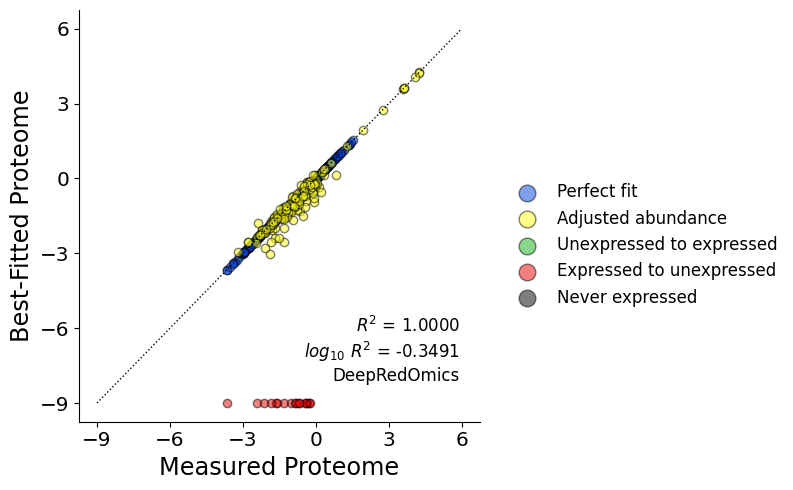

In [20]:
nrows, ncols = (1, 1)
length=5
r2_text_loc = "lower right"
transform = True
fig, ax = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(length * ncols, length * nrows),
    sharex=True,
    sharey=True,
)
sns.despine(fig)

df_qp_sol, r2, r2_log10, objective_value = qp_solutions_dict[sample_id]
# Copy to prevent alterations to the original
df_qp_sol = df_qp_sol.copy()
xlabel, ylabel = df_qp_sol.columns

ticks = 10**np.arange(*np.log10([log_zero_replacement, 1e8]), 3)
if transform:
    ticks = np.log10(ticks)
    df_qp_sol.iloc[:, 0] = df_qp_sol.iloc[:, 0].apply(lambda x: log_zero_replacement if np.isclose(x, 0) else x).apply(np.log10)
    df_qp_sol.iloc[:, 1] = df_qp_sol.iloc[:, 1].apply(lambda x: log_zero_replacement if np.isclose(x, 0) else x).apply(np.log10)
perfect_fit_line = ax.plot(
    [ticks[0], ticks[-1]],
    [ticks[0], ticks[-1]],
    linestyle=":",
    color="black",
    linewidth=1,
    alpha=1,
)

zero_val = 0 if not transform else np.log10(log_zero_replacement)

df_zeros = df_qp_sol[(df_qp_sol.apply(lambda x: np.isclose(x, zero_val))).any(axis=1)]
df_perfect = df_qp_sol[
    np.isclose(
        abs(df_qp_sol["Measured Proteome"] - df_qp_sol["Best-Fitted Proteome"]), 0
    )
]
df_perfect = df_perfect[~df_perfect.index.isin(df_zeros.index)]

df_altered = df_qp_sol[
    ~np.isclose(
        abs(df_qp_sol["Measured Proteome"] - df_qp_sol["Best-Fitted Proteome"]), 0
    )
]
df_altered = df_altered[~df_altered.index.isin(df_zeros.index)]
df_always_zero = df_zeros[(df_zeros == zero_val).all(axis=1)]
df_zeros = df_zeros[~df_zeros.index.isin(df_always_zero.index)]
df_from_zeros = df_zeros[np.isclose(df_zeros["Measured Proteome"], zero_val)]
df_to_zeros = df_zeros[np.isclose(df_zeros["Best-Fitted Proteome"], zero_val)]

handles = [
    ax.scatter(
        data=df_perfect.replace(0, ticks[0]),
        x=xlabel,
        y=ylabel,
        color="xkcd:blue",
        alpha=0.5,
        edgecolors="black",
        linewidths=1,
    ),
    ax.scatter(
        data=df_altered.replace(0, ticks[0]),
        x=xlabel,
        y=ylabel,
        color="xkcd:yellow",
        alpha=0.5,
        edgecolors="black",
        linewidths=1,
    ),
    ax.scatter(
        data=df_from_zeros.replace(0, ticks[0]),
        x=xlabel,
        y=ylabel,
        color="xkcd:green",
        alpha=0.5,
        edgecolors="black",
        linewidths=1,
    ),
    ax.scatter(
        data=df_to_zeros.replace(0, ticks[0]),
        x=xlabel,
        y=ylabel,
        color="xkcd:red",
        alpha=0.5,
        edgecolors="black",
        linewidths=1,
    ),
    ax.scatter(
        data=df_always_zero.replace(0, ticks[0]),
        x=xlabel,
        y=ylabel,
        color="xkcd:black",
        alpha=0.5,
        edgecolors="black",
        linewidths=1,
    ),
]
labels = [
    f"Perfect fit",
    f"Adjusted abundance",
    f"Unexpressed to expressed",
    f"Expressed to unexpressed",
    f"Never expressed",
]

sample_label = dataset_name
if not transform:
    ax.set_xscale("log")
    ax.set_yscale("log")

fontdict = {"size": "xx-large"}
ax.set_xlabel(xlabel, fontdict=fontdict)
ax.set_ylabel(ylabel, fontdict=fontdict)

fig.legend(
    handles=handles,
    labels=labels,
    loc="center left",
    ncols=1,
    frameon=False,
    fontsize="large",
    markerscale=2,
    bbox_to_anchor=(1, 0.5),
)
ax.set_xticks(ticks)
ax.set_yticks(ticks)

ax.xaxis.set_tick_params(labelsize="x-large")
ax.yaxis.set_tick_params(labelsize="x-large")

ax.set_xticks(ticks)
ax.set_yticks(ticks)

ax.xaxis.set_tick_params(labelsize="x-large")
ax.yaxis.set_tick_params(labelsize="x-large")

r2_format = " = {:.4f}"
if r2_text_loc == "lower right":
    ax.text(
        0.95,
        0.1,
        "\n".join((r"$R^{2}$" + r2_format.format(r2), r"$log_{10}\ R^{2} $" + r2_format.format(r2_log10), sample_label)),
        transform=ax.transAxes,
        color="black",
        fontsize="large",
        ha="right",
    )
elif r2_text_loc == "upper left":
    ax.text(
        0.05,
        0.9,
        "\n".join((r"$R^{2}$" + r2_format.format(r2), r"$log_{10}\ R^{2} $" + r2_format.format(r2_log10), sample_label)),
        transform=ax.transAxes,
        color="black",
        fontsize="large",
        ha="left",
    )
else:
    pass
fig.tight_layout()
if save_figures:
    fig.savefig(
        fitting_dirpath / f"QPfitting_{'' if not transform else 'log10_'}{model_id}.{imagetype}",
        transparent=transparent,
        format=imagetype,
    )

### Determine best value for slack variables

In [21]:
list_of_pcmodels = []
verbose = False
objective_rxns = ["NaKt"]

slack_min = 1e-5  # Slack %
slack_max = 1.5
if run_computations:
    df_qp_sol, r2, r2_log10, objective_value = qp_solutions_dict[sample_id]
    # Create a copy of the model
    pcmodel_sample = pcmodel.copy()
    pcmodel_sample.id = f"{pcmodel.id}_{sample_id}"
    for protdl in pcmodel_sample.reactions.query(
        lambda x: isinstance(x, ProteinDilution)
    ):
        if protdl.id in df_qp_sol.index:
            prot_bound = df_qp_sol.loc[protdl.id]["Best-Fitted Proteome"]
        else:
            prot_bound = 0
        protdl.bounds = (float(prot_bound), float(prot_bound))
    # Add the relaxation budget with slack = 0 first
    add_relaxation_budget(pcmodel_sample, 0, int(verbose))
    list_of_pcmodels += [pcmodel_sample]

    solutions = {
        pcmodel_sample.id: {
            "model": [],
            "slack": [],
            "objective": [],
            "relaxation": [],
            "_".join(objective_rxns): [],
        }
        for pcmodel_sample in list_of_pcmodels
    }
    for slack_value in np.geomspace(slack_min, slack_max, 501):
        if int(verbose):
            print(f"Updating slack variable to {100 * slack_value:.6f}%.")
        for pcmodel_sample in list_of_pcmodels:
            update_slack_value(pcmodel_sample, slack_value, verbose=False)
            relaxation_demand = pcmodel_sample.reactions.get_by_id(
                f"PBDL_relaxation_budget"
            )
            pcmodel_sample.objective = (
                sum(
                    [
                        r.flux_expression
                        for r in pcmodel_sample.reactions.get_by_any(objective_rxns)
                    ]
                )
                - relaxation_demand.flux_expression
            )
            pcmodel_sample.objective_direction = "max"
            sol = pcmodel_sample.optimize()
            obj_value = sol.objective_value
            if not obj_value or np.isnan(obj_value):
                if int(verbose) > 1:
                    print(f"No solution for {100 * slack_value:.6f}%\n.")
                continue
            else:
                demand = relaxation_demand.flux
                budget = relaxation_demand.upper_bound
            solutions[pcmodel_sample.id]["model"].append(pcmodel_sample.id)
            solutions[pcmodel_sample.id]["slack"].append(slack_value)
            solutions[pcmodel_sample.id]["objective"].append(obj_value)
            solutions[pcmodel_sample.id]["_".join(objective_rxns)].append(
                obj_value + demand
            )
            solutions[pcmodel_sample.id]["relaxation"].append(demand / budget)
    solutions = {
        pcmodel_sample_id: pd.DataFrame.from_dict(sol)
        for pcmodel_sample_id, sol in solutions.items()
    }

    df_relaxation = pd.concat(list(solutions.values()), axis=0)
    df_relaxation.to_csv(
        fitting_dirpath / f"SlackPercentDeterminationData_{model_id}.tsv",
        sep="\t",
        index=False,
    )
else:
    df_relaxation = pd.read_csv(
        fitting_dirpath / f"SlackPercentDeterminationData_{model_id}.tsv", sep="\t"
    )
    solutions = {
        mid: df_relaxation[df_relaxation["model"] == mid].drop("model", axis=1)
        for mid in df_relaxation["model"].unique()
    }          
df_relaxation

/Users/zhaiman/opt/miniconda3/envs/memote-rbc-gem/lib/python3.11/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


,model,slack,objective,relaxation,NaKt
0,RBC_GEM_PC_DeepRedOmics,0.001148,0.024361,0.006146,0.031203
1,RBC_GEM_PC_DeepRedOmics,0.001176,0.024443,0.006211,0.031525
2,RBC_GEM_PC_DeepRedOmics,0.001204,0.024529,0.006280,0.031862
3,RBC_GEM_PC_DeepRedOmics,0.001234,0.024620,0.006352,0.032216
4,RBC_GEM_PC_DeepRedOmics,0.001263,0.024714,0.006428,0.032587
...,...,...,...,...,...
297,RBC_GEM_PC_DeepRedOmics,1.363586,0.049199,0.000086,0.162405
298,RBC_GEM_PC_DeepRedOmics,1.396480,0.049199,0.000084,0.162405
299,RBC_GEM_PC_DeepRedOmics,1.430167,0.049199,0.000082,0.162405
300,RBC_GEM_PC_DeepRedOmics,1.464668,0.049199,0.000080,0.162405


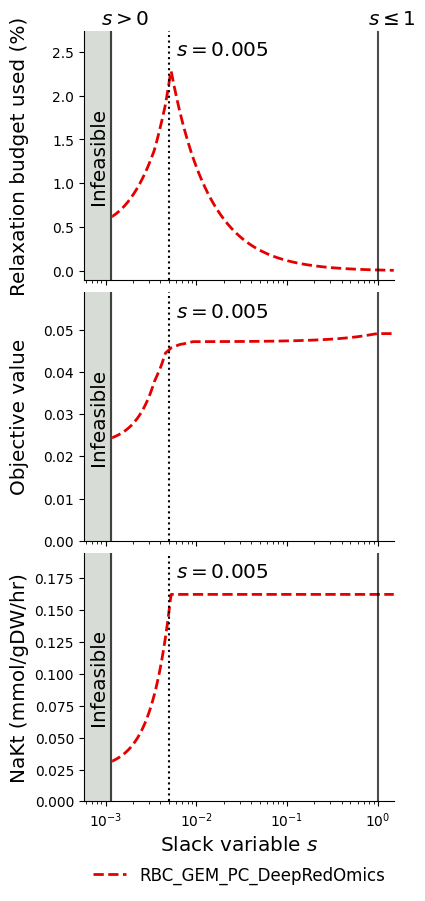

In [22]:
fig, axes = plt.subplots(
    3, 1, figsize=(4, 10), sharex=True, gridspec_kw=dict(hspace=0.05)
)
axes = axes.flatten()

# ax3d = fig.add_subplot(2, 2, 4, projection="3d")
sns.despine(fig)

handles = []
labels = []
chosen_slack_var = 0.005
use_percents = True
logscale_slack = True
linestyle = "--"
color="xkcd:red"
for pcmodel_sample_id in list(solutions):

    labels.append(pcmodel_sample_id)
    s_values = solutions[str(pcmodel_sample_id)]["slack"].values
    r_values = solutions[str(pcmodel_sample_id)]["relaxation"].values * (
        100 if use_percents else 1
    )
    o_values = solutions[str(pcmodel_sample_id)]["objective"].values
    rxn_values = solutions[str(pcmodel_sample_id)]["_".join(objective_rxns)].values

    zorder = 1
    lw = 2
    axes[0].plot(
        s_values,
        r_values,
        label=str(pcmodel_sample_id),
        color=color,
        linestyle=linestyle,
        linewidth=lw,
        zorder=zorder,
    )
    axes[1].plot(
        s_values,
        o_values,
        label=str(pcmodel_sample_id),
        color=color,
        linestyle=linestyle,
        linewidth=lw,
        zorder=zorder,
    )
    axes[2].plot(
        s_values,
        rxn_values,
        label=str(pcmodel_sample_id),
        color=color,
        linestyle=linestyle,
        linewidth=lw,
        zorder=zorder,
    )

    # index = list(s_values).index(s_values[s_values >= chosen_slack_var][0])
    # spt = s_values[index]
    # rpt = r_values[index]
    # opt = o_values[index]
    # rxnpt = rxn_values[index]
    # c = "black"
    # ls = ""
    # marker = "o"
    # markersize = 8
    # axes[0].plot(spt, rpt, color=c, linestyle=ls, marker=marker, markersize=markersize)
    # axes[1].plot(spt, opt, color=c, linestyle=ls, marker=marker, markersize=markersize)
    # axes[2].plot(spt, rxnpt, color=c, linestyle=ls, marker=marker, markersize=markersize)
    # # ax3d.plot(spt, rpt, opt, color=c, linestyle=ls, marker=marker, markersize=markersize)
    # print(f"Elbow point for {pcmodel_sample_id}: approx. ({spt:.5f}, {rpt:.5f}, {opt:.5f})")
fontdict = {"size": "x-large"}
axes[-1].set_xlabel(r"Slack variable $s$", fontdict=fontdict)
    
zorder = 2
alpha = 0.7
limit_pad_sclar = 1.2
smin = s_values[0]




for i, ax in enumerate(axes):
    if i == 0:
        ymin, ymax = (-0.001 * (100 if use_percents else 1), max(r_values) * limit_pad_sclar)
    elif i == 1:
        ymin, ymax = (min(0, min(o_values)) * limit_pad_sclar, max(o_values) * limit_pad_sclar)
    elif i == 2:
        ymin, ymax = (0, max(rxn_values) * limit_pad_sclar)
    else:
        pass
    ax.vlines(chosen_slack_var, ymin=ymin, ymax=ymax, color="black", linestyle=":")
    ax.vlines(
        smin, ymin=ymin, ymax=ymax, color="black", linestyle="-", zorder=zorder, alpha=alpha
    )
    ax.vlines(
        1, ymin=ymin, ymax=ymax, color="black", linestyle="-", zorder=zorder, alpha=alpha
    )
    ax.set_xlim(smin / 2, slack_max)
    ax.set_ylim(ymin, ymax)
    ax.set_xscale("log")
    ax.annotate(
        rf"$s = {chosen_slack_var}$",
        xy=(chosen_slack_var, ymax*0.9),
        xycoords="data",
        xytext=(5, 0),
        textcoords="offset points",
        ha="left",
        fontsize=fontdict["size"],
    )
    if i == 0:
        ax.annotate(
            rf"$s > 0$",
            xy=(smin, ymax),
            xycoords="data",
            xytext=(10, 5),
            textcoords="offset points",
            ha="center",
            fontsize=fontdict["size"],
        )
        ax.annotate(
            rf"$s \leq 1$",
            xy=(1, ymax),
            xycoords="data",
            xytext=(10, 5),
            textcoords="offset points",
            ha="center",
            fontsize=fontdict["size"],
        )
    ax.fill_between((smin / 2, smin), ymin, ymax, color="xkcd:light grey")
    ax.annotate(
        "Infeasible",
        xy=(smin, (ymax + ymin) / 2),
        xycoords="data",
        rotation=90,
        xytext=(-2, 0),
        textcoords="offset points",
        va="center",
        ha="right",
        fontsize=fontdict["size"],
    )


handles, labels = axes[2].get_legend_handles_labels()
axes[2].legend(
    handles=handles,
    labels=labels,
    ncols=1,
    frameon=False,
    loc="upper center",
    fontsize="large",
    bbox_to_anchor=(0.5, -0.2),
)


axes[0].set_ylabel("Relaxation budget used (%)", fontdict=fontdict)
axes[1].set_ylabel("Objective value", fontdict=fontdict)
axes[2].set_ylabel("NaKt (mmol/gDW/hr)", fontdict=fontdict)

fig.align_labels()
if save_figures:
    fig.savefig(
        fitting_dirpath / f"SlackPercentDetermination_{model_id}.{imagetype}",
        transparent=transparent,
        format=imagetype,
    )

### Formulate models from QP solutions

In [ ]:
list_of_relaxed_models = []
slack_value = chosen_slack_var  # Slack %
verbose = True

# In our experience, SBML/XML loads faster, but will take up to 4x more space uncompressed as compared to JSON
ftypes = {
    "xml"
    # "json",
}

model_values = {}
ftypes = set([ftypes]) if isinstance(ftypes, str) else set(ftypes)
for sample_id, (df_qp_sol, r2, r2_log10, objective_value) in qp_solutions_dict.items():
    # Create a copy of the model
    sample_id = f"{pcmodel.id}_{sample_id}"
    filenames = [sample_pcmodels_dirpath / f"{sample_id}.{ftype}" for ftype in ftypes]
    if all([filename.exists() for filename in filenames]):
        print(f"Model already created for {sample_id}")
        continue
    pcmodel_sample = pcmodel.copy()
    pcmodel_sample.id = sample_id
    for protdl in pcmodel_sample.reactions.query(
        lambda x: isinstance(x, ProteinDilution)
    ):
        if protdl.id in df_qp_sol.index:
            prot_bound = df_qp_sol.loc[protdl.id]["Best-Fitted Proteome"]
        else:
            prot_bound = 0
        protdl.bounds = (float(prot_bound), float(prot_bound))
    # Add the relaxation budget
    add_relaxation_budget(pcmodel_sample, slack_value, verbose)
    # # Store model for later use
    # list_of_relaxed_models += [pcmodel_sample]
    for filename in filenames:
        # Might as well overwrite all files, especially if model needed to be regenerated anyways
        write_cobra_model(
            pcmodel_sample,
            filename=filename,
        )

Relaxation budget added to RBC_GEM_PC_DeepRedOmics, extra 4.8474 mg/gDW (4.7500 mg HB/gDW) from 0.5000% slack
